In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np

from src.sampler import HMCSampler, MetropolisHastingsSampler
from src.density import NealsFunnel


# Define distribution

In [2]:
neals_funnel = NealsFunnel(dim=2, sigma_y=3.0)
hmc = HMCSampler(neals_funnel)

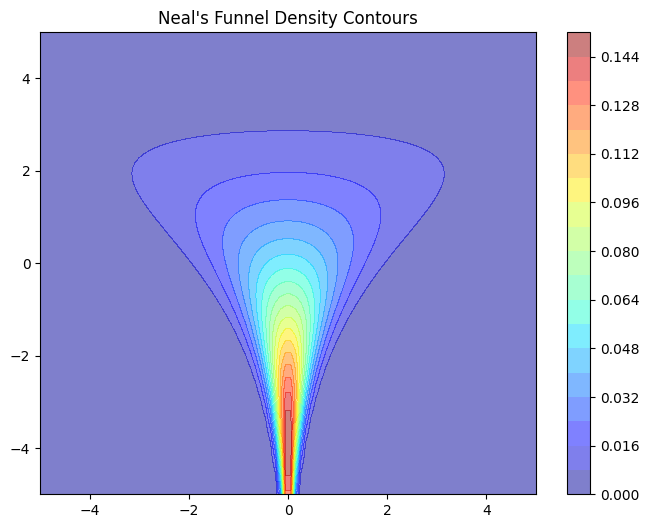

In [3]:
# plot custom_gaussian.f() function between [-5, -5, 5, 5]
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))

fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(X, Y, Z, levels=20, cmap="jet", alpha=0.5)
ax.set_title("Neal's Funnel Density Contours")
plt.colorbar(cs)
plt.show()


# Hamiltonian Monte Carlo Sampling

## Leapfrog a couple of samples

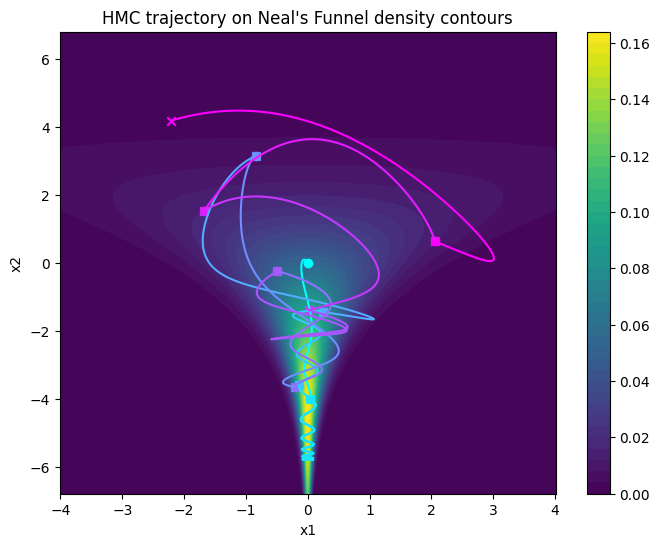

In [ ]:
# Single long trajectory for visualisation
q0 = np.array([0.0, -0.0])
n_paths = 10
paths = []
for _ in range(n_paths):
    p0 = np.random.normal(size=2)
    # qT, pT, path = leapfrog(
    #     q0, p0, step_size=0.05, n_steps=100, grad_U=grad_U, return_path=True
    # )
    q0, pT, path = hmc.leapfrog(x=q0, p=p0, leapfrog_steps=100, step_size=0.05)
    paths.append(path)

# Plot results
# Grid and contour plot
x_lim = (
    max(
        abs(np.min([path[:, 1].min() for path in paths])),
        abs(np.max([path[:, 1].max() for path in paths])),
    )
    + 1
)
y_lim = (
    max(
        abs(np.min([path[:, 0].min() for path in paths])),
        abs(np.max([path[:, 0].max() for path in paths])),
    )
    + 1
)

xs = np.linspace(-x_lim, x_lim, 500)
ys = np.linspace(-y_lim, y_lim, 500)

X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))


fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")

# ax.clabel(cs, inline=True, fontsize=8)
colors = plt.cm.cool(np.linspace(0, 1, n_paths))
for i, path in enumerate(paths):
    ax.plot(path[:, 1], path[:, 0], color=colors[i])
    ax.scatter(path[0, 1], path[0, 0], marker="o", color=colors[i])
    ax.scatter(path[-1, 1], path[-1, 0], marker="x", color=colors[i])
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC trajectory on Neal's Funnel density contours")

plt.colorbar(cs)
plt.show()

## Sample points

In [12]:
# np.random.seed(0)

dim = 2
n_samples = 1000
leapfrog_steps = 20
step_size = 0.1
initial_q = np.array([0.0, 0.0])

start = perf_counter()
samples_hmc, acceptance_rate_hmc = hmc.sample(
    n_samples,
    leapfrog_steps,
    initial_q,
    step_size,
    dim,
)
time_hmc = perf_counter() - start

print(f"HMC sampling took {time_hmc:.3f} seconds.")
print(f"HMC acceptance rate: {acceptance_rate_hmc:.3f}")

HMC sampling took 0.148 seconds.
HMC acceptance rate: 0.980


## Plot samples

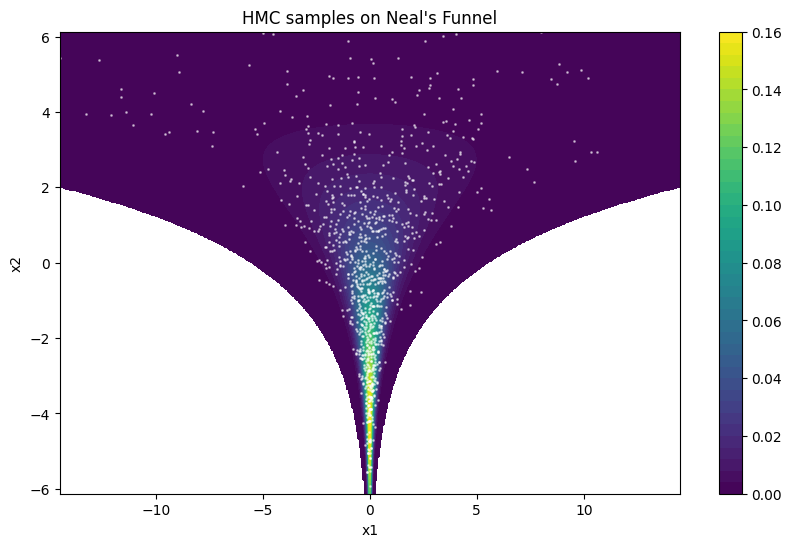

In [13]:
# Plot samples on top of contour plot
fig, ax = plt.subplots(figsize=(10, 6))

min_x, max_x = min(samples_hmc[:, 1]), max(samples_hmc[:, 1])
x_lim = max(abs(min_x), abs(max_x))
min_y, max_y = min(samples_hmc[:, 0]), max(samples_hmc[:, 0])
y_lim = max(abs(min_y), abs(max_y))

xs = np.linspace(-x_lim, x_lim, 500)
ys = np.linspace(-y_lim, y_lim, 500)

X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))
Z = np.ma.masked_where(np.isclose(Z, 0), Z)

cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
ax.scatter(samples_hmc[:, 1], samples_hmc[:, 0], color="w", s=1, alpha=0.5, zorder=2)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC samples on Neal's Funnel")
plt.colorbar(cs)
plt.show()

# Metropolis Hastings Sampling

In [7]:
metropolis_sampler = MetropolisHastingsSampler(neals_funnel)

In [14]:
# Plot the full path of Metropolis samples
q0 = np.array([0.0, -2.0])
start = perf_counter()
samples_metropolis, acc_rate = metropolis_sampler.sample(
    n_samples,
    proposal_scale=0.5,
    dim=dim,
    initial_q=q0,
)
time_metropolis = perf_counter() - start

print(f"Metropolis sampling took {time_metropolis:.3f} seconds.")
print(f"Metropolis acceptance rate: {acc_rate:.3f}")

Metropolis sampling took 0.023 seconds.
Metropolis acceptance rate: 0.721


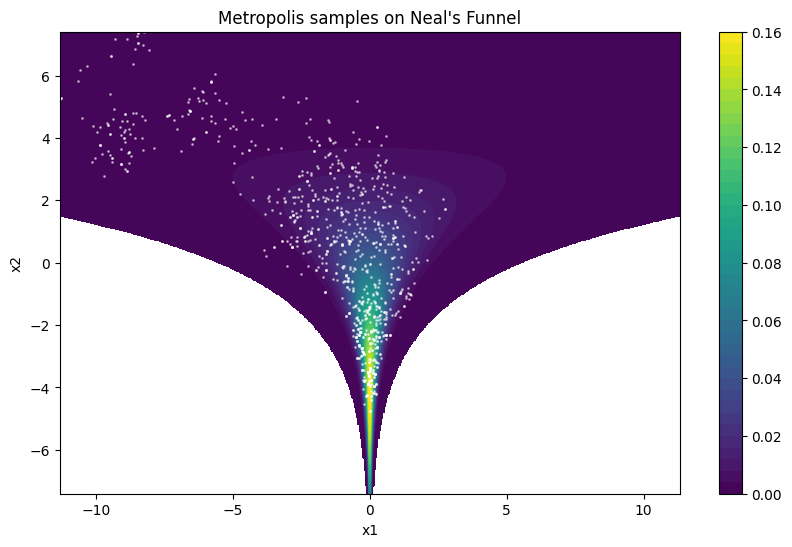

In [15]:
# Plot samples on top of contour plot
fig, ax = plt.subplots(figsize=(10, 6))

min_x, max_x = min(samples_metropolis[:, 1]), max(samples_metropolis[:, 1])
x_lim = max(abs(min_x), abs(max_x))
min_y, max_y = min(samples_metropolis[:, 0]), max(samples_metropolis[:, 0])
y_lim = max(abs(min_y), abs(max_y))

xs = np.linspace(-x_lim, x_lim, 500)
ys = np.linspace(-y_lim, y_lim, 500)

X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = neals_funnel(np.array([Y[i, j], X[i, j]]))
Z = np.ma.masked_where(np.isclose(Z, 0), Z)

cs = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
ax.scatter(
    samples_metropolis[:, 1],
    samples_metropolis[:, 0],
    color="w",
    s=1,
    alpha=0.5,
    zorder=2,
)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Metropolis samples on Neal's Funnel")
plt.colorbar(cs)
plt.show()
